In [1]:
import random
import string
from sklearn import linear_model
from collections import defaultdict
import scipy.optimize
import nltk
from nltk.stem.porter import *
from nltk.corpus import stopwords
import numpy
%matplotlib inline
import pandas as pd
import math
import matplotlib.pyplot as plt

In [2]:
data = []  

with open('moviesfin.txt') as file:
    i = 0
    for line in file:
        arr = line.split(",")
        if (arr == ['title', 'date', 'runtime', 'genre', 'rating', 'description', 'votes', 'gross\n']):
            continue
        yr = arr[1]
        if (len(arr[1].split()) > 1):
            yr = arr[1].split()[1]
        vot = arr[6]
        if vot == "NaN":
            vot = 0
        rat = arr[4]
        if rat == "NaN":
            rat = 0
        gross = arr[7].replace('\n','')
        if gross.strip() == "NaN":
            gross = 0
        else:
            gross = gross[1:(len(gross)-1)]
            gross = float(gross) * 1000000
        desc = arr[5]
        if desc.strip() == "add a plot":
            desc = ''
        elif desc.find('see full summary »') != -1:
            desc = desc.replace('see full summary »', '')
        
        d = {"title":arr[0], "date":int(yr), "runtime":arr[2], "genres":arr[3], "rating":float(rat), "desc":desc, "votes":int(vot), "gross":float(gross)}
        data.append(d)
            

In [3]:
title = []
date = []
runtime = []
genres = []
rating = []
desc = []
votes = []
gross = []
for val in data:
    title.append(val['title'])
    date.append(val['date'])
    runtime.append(val['runtime'])
    genres.append(val['genres'])
    rating.append(val['rating'])
    desc.append(val['desc'])
    votes.append(val['votes'])
    gross.append(val['gross'])
yrrange = numpy.arange(2000, 2021)
yearId = dict(zip(yrrange, range(len(yrrange))))
yeary = [0] * len(yrrange)
for val in data:
    yeary[yearId[val['date']]] += 1

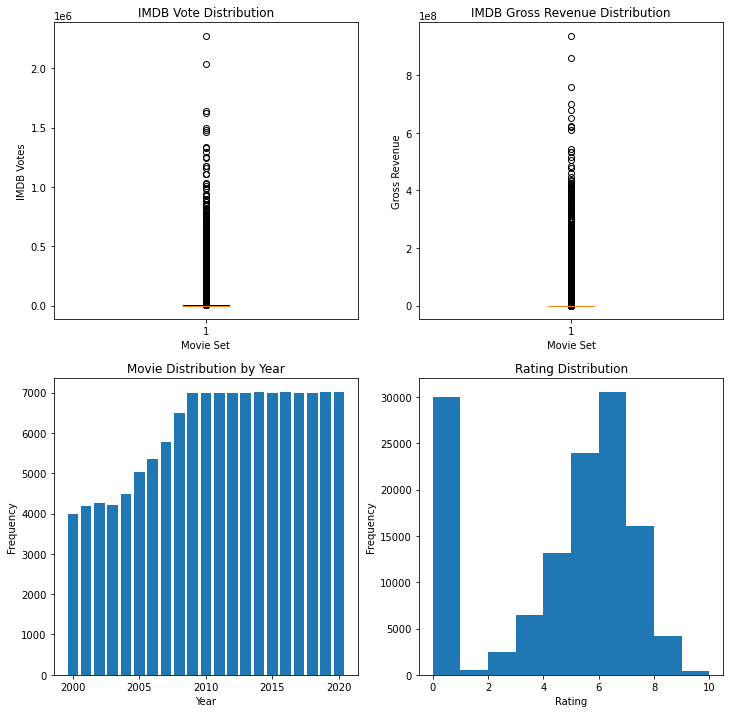

In [4]:
plt.rcParams['figure.figsize'] = [12, 12]
fig, axs = plt.subplots(2, 2)
vot = axs[0,0].boxplot(votes)
axs[0,0].set_title('IMDB Vote Distribution')
axs[0,0].set_xlabel('Movie Set')
axs[0,0].set_ylabel('IMDB Votes')
rev = axs[0,1].boxplot(gross)
axs[0,1].set_title('IMDB Gross Revenue Distribution')
axs[0,1].set_xlabel('Movie Set')
axs[0,1].set_ylabel('Gross Revenue')
axs[1,0].set_title('Movie Distribution by Year')
axs[1,0].set_xlabel('Year')
axs[1,0].set_ylabel('Frequency')
axs[1,0].bar(yrrange, yeary)
axs[1,1].set_title('Rating Distribution')
axs[1,1].set_ylabel('Frequency')
axs[1,1].set_xlabel('Rating')
axs[1,1].hist(rating)
plt.show()

In [5]:
print('Votes')
print([d.get_ydata()[1] for d in vot['whiskers']])
top_points = vot["fliers"][0].get_data()[1]
print(len(top_points))
print('Revenue')
print([d.get_ydata()[1] for d in rev['whiskers']])
top_points = rev["fliers"][0].get_data()[1]
print(len(top_points))

Votes
[0.0, 771.0]
20734
Revenue
[0.0, 0.0]
8020


In [6]:
# include top words in descriptions and titles
# average votes by rating and year
titlew = defaultdict(int)
descw = defaultdict(int)

punctuation = set(string.punctuation) # punctuation
stops = stopwords.words('english') # stop words
stops2 = stopwords.words('spanish')

for val in data:
    curr = ''.join([c for c in val['title'].lower() if c not in punctuation])
    for c in curr.split():
        if c not in stops and c not in stops2:
            titlew[c] += 1
    curr = ''.join([c for c in val['desc'].lower() if c not in punctuation])
    for c in curr.split():
        if c not in stops and c not in stops2:
            descw[c] += 1
    
titlew = [(titlew[w], w) for w in titlew] # sort from most frequent to least
titlew.sort()
titlew.reverse() 

descw = [(descw[w], w) for w in descw] # sort conditons
descw.sort()
descw.reverse() 

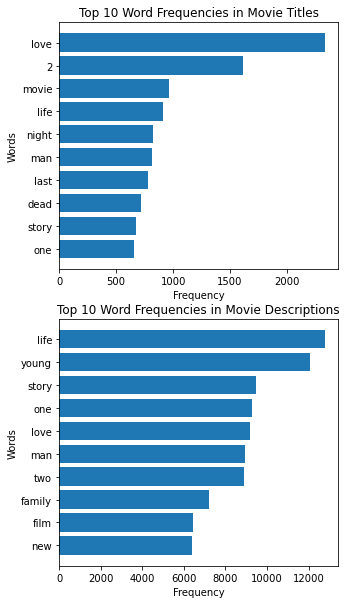

In [7]:
plt.rcParams['figure.figsize'] = [5, 10]
fig, axs = plt.subplots(2, 1)

tmp = titlew[0:10]
tmp.reverse()
axs[0].barh([d[1] for d in tmp], [d[0] for d in tmp])
axs[0].set_title('Top 10 Word Frequencies in Movie Titles')
axs[0].set_ylabel('Words')
axs[0].set_xlabel('Frequency')

tmp = descw[0:10]
tmp.reverse()
axs[1].barh([d[1] for d in tmp], [d[0] for d in tmp])
axs[1].set_title('Top 10 Word Frequencies in Movie Descriptions')
axs[1].set_ylabel('Words')
axs[1].set_xlabel('Frequency')

plt.show()

In [8]:
df = {"title":title, "date":date, "runtime":runtime, "genre":genres, "rating":rating, "description":desc, "votes":votes, "gross":gross}
df = pd.DataFrame(df)
df.head()

,title,date,runtime,genre,rating,description,votes,gross
0,How the Grinch Stole Christmas,2000,104,Comedy~Family~Fantasy,6.2,on the outskirts of whoville lives a green rev...,201170,260040000.0
1,Gladiator,2000,155,Action~Adventure~Drama,8.5,a former roman general sets out to exact venge...,1324233,187710000.0
2,Requiem for a Dream,2000,102,Drama,8.3,the druginduced utopias of four coney island p...,757816,3640000.0
3,American Psycho,2000,101,Comedy~Crime~Drama,7.6,a wealthy new york city investment banking exe...,482249,15070000.0
4,Almost Famous,2000,122,Adventure~Comedy~Drama,7.9,a highschool boy is given the chance to write ...,250248,32530000.0


In [9]:
# average votes by rating and year
yeararr = numpy.arange(min(df['date']), max(df['date']) + 1) # average useful count for each year
yeary = []
for year in yeararr:
    tmp = df[df['date'] == year]
    avg = sum(tmp['votes'])/len(tmp['votes'])
    yeary.append(avg)
ratingarr = numpy.arange(0,11)
ratingy = []
for rat in ratingarr:
    tmp = df[(df['rating'] >= rat) & (df['rating'] < (rat + 1))]
    avg = sum(tmp['votes'])/len(tmp['votes'])
    ratingy.append(avg)

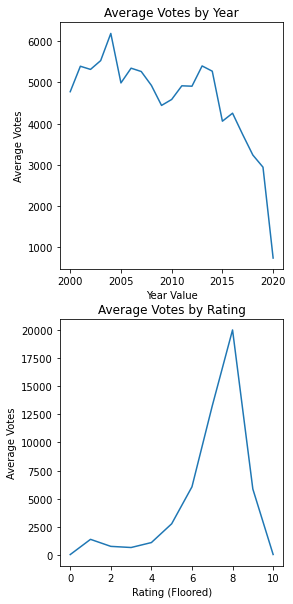

In [10]:
plt.rcParams['figure.figsize'] = [4, 10]
fig, axs = plt.subplots(2, 1)

axs[0].plot(yeararr, yeary) 
axs[0].set_xlabel('Year Value')
axs[0].set_ylabel('Average Votes')
axs[0].set_title('Average Votes by Year')

axs[1].plot(ratingarr, ratingy)
axs[1].set_xlabel('Rating (Floored)')
axs[1].set_ylabel('Average Votes')
axs[1].set_title('Average Votes by Rating')
plt.show()

In [11]:
print((df['runtime'] == "NaN").sum())
print((df['genre'] == "NaN").sum())
print((df['rating'] == 0).sum())
print((df['description'] == "NaN").sum())
print((df['votes'] == 0).sum())
print((df['gross'] == 0).sum())

21674
7435
30030
0
30031
119808


In [12]:
trainsize = int(len(data) * 0.8)
validsize = (len(data) - trainsize) // 2
testsize = len(data) - trainsize - validsize
print(len(data))
print(trainsize)
print(validsize)
print(testsize)

127828
102262
12783
12783


In [49]:
random.shuffle(data)
train = data[0:trainsize]
valid = data[trainsize:(trainsize + validsize)]
test = data[(trainsize + validsize):]
print(len(train))
print(len(valid))
print(len(test))

102262
12783
12783


In [50]:
y_train = []
y_valid = []
y_test = []
for val in train:
    y_train.append(val['votes'])
for val in valid:
    y_valid.append(val['votes'])
for val in test:
    y_test.append(val['votes'])

In [51]:
rating = []
for val in train:
    rating.append(val['votes'])
avg = sum(rating)/len(rating)
print(avg)

4551.372513739218


In [52]:
pred = [avg] * len(valid) # BASELINE MODEL MSES
base_valid = numpy.square(numpy.subtract(pred, y_valid)).mean()
print(base_valid)
pred = [avg] * len(test)
base_test = numpy.square(numpy.subtract(pred, y_test)).mean()
print(base_test)

1160280500.6441615
1003771021.5308051


In [53]:
# available features: title, date, runtime, genre, rating, description, votes, gross revenue
# date (one-hot)**
# runtime
# genre (one-hot)
# rating***
# description (bag-of-words) TODO 
# revenue***
# title (bag-of-words) TODO
g = set([])
for val in df['genre']:
    arr = val.strip().split('~')
    for a in arr:
        g.add(a)

In [54]:
yrs = numpy.arange(2000, 2021) # LSTSQ using year, rating, revenue, genres
yearId = dict(zip(yrs, range(len(yrs))))
gens = list(g)
gensId = dict(zip(gens, range(len(gens))))
titlepop = [d[1] for d in titlew[0:250]]
titleId = dict(zip(titlepop, range(len(titlepop))))
descpop = [d[1] for d in descw[0:5000]]
descId = dict(zip(descpop, range(len(descpop))))
def feature1(datum): # year, rating, gross, genres
    y = [0] * len(yrs) 
    y[yearId[datum['date']]] = 1
    rcurr = float(datum['rating'])
    gcurr = float(datum['gross'])
    feats = [1, rcurr, gcurr] 
    y += feats
    glist = [0] * len(gens)
    tmp = datum['genres'].strip().split('~')
    for t in tmp:
        glist[gensId[t]] = 1
    y += glist
    return y
def feature2(datum): # rating, gross, genres
    rcurr = float(datum['rating'])
    gcurr = float(datum['gross'])
    y = [1, rcurr, gcurr] 
    glist = [0] * len(gens)
    tmp = datum['genres'].strip().split('~')
    for t in tmp:
        glist[gensId[t]] = 1
    y += glist
    return y
def feature3(datum): # year, rating, gross
    y = [0] * len(yrs) 
    y[yearId[datum['date']]] = 1
    rcurr = float(datum['rating'])
    gcurr = float(datum['gross'])
    feats = [1, rcurr, gcurr] 
    y += feats
    return y
def feature4(datum): # year, rating, gross, genres, rating^2, gross^2
    y = [0] * len(yrs) 
    y[yearId[datum['date']]] = 1
    rcurr = float(datum['rating'])
    gcurr = float(datum['gross'])
    feats = [1, rcurr, gcurr, rcurr**2, gcurr**2] 
    y += feats
    glist = [0] * len(gens)
    tmp = datum['genres'].strip().split('~')
    for t in tmp:
        glist[gensId[t]] = 1
    y += glist
    return y
def feature5(datum): # year, rating, gross, genres, rating^2
    y = [0] * len(yrs) 
    y[yearId[datum['date']]] = 1
    rcurr = float(datum['rating'])
    gcurr = float(datum['gross'])
    feats = [1, rcurr, gcurr, rcurr**2] 
    y += feats
    glist = [0] * len(gens)
    tmp = datum['genres'].strip().split('~')
    for t in tmp:
        glist[gensId[t]] = 1
    y += glist
    return y
def feature6(datum): # year, rating, gross, genres, gross^2
    y = [0] * len(yrs) 
    y[yearId[datum['date']]] = 1
    rcurr = float(datum['rating'])
    gcurr = float(datum['gross'])
    feats = [1, rcurr, gcurr, gcurr**2] 
    y += feats
    glist = [0] * len(gens)
    tmp = datum['genres'].strip().split('~')
    for t in tmp:
        glist[gensId[t]] = 1
    y += glist
    return y
def feature7(datum): # year, rating, gross, genres, gross^2, descwords
    y = [0] * len(yrs) 
    y[yearId[datum['date']]] = 1
    rcurr = float(datum['rating'])
    gcurr = float(datum['gross'])
    feats = [1, rcurr, gcurr, gcurr**2] 
    y += feats
    glist = [0] * len(gens)
    tmp = datum['genres'].strip().split('~')
    for t in tmp:
        glist[gensId[t]] = 1
    y += glist
    wf = [0] * len(descpop)
    tmp = ''.join([c for c in datum['desc'].lower() if c not in punctuation])
    for c in tmp.split():
        if c in descpop:
            wf[descId[c]] += 1
    y += wf
    return y
def feature8(datum): # year, rating, gross, genres, rating^2, gross^2, runtime
    y = [0] * len(yrs) 
    y[yearId[datum['date']]] = 1
    rcurr = float(datum['rating'])
    gcurr = float(datum['gross'])
    run = datum['runtime']
    if run == "NaN":
        run = 96.779
    feats = [1, rcurr, gcurr, rcurr**2, gcurr**2, float(run)] 
    y += feats
    glist = [0] * len(gens)
    tmp = datum['genres'].strip().split('~')
    for t in tmp:
        glist[gensId[t]] = 1
    y += glist
    return y

In [55]:
print('year, rating, gross, genres')
X_train = [feature1(d) for d in train]
X_valid = [feature1(d) for d in valid]
X_test = [feature1(d) for d in test]
mod = linear_model.LinearRegression().fit(X_train, y_train)
pred = mod.predict(X_valid)
lstsq_valid = numpy.square(numpy.subtract(pred, y_valid)).mean()
print(lstsq_valid)
pred = mod.predict(X_test)
lstsq_test = numpy.square(numpy.subtract(pred, y_test)).mean()
print(lstsq_test)
print('rating, gross, genres')
X_train = [feature2(d) for d in train]
X_valid = [feature2(d) for d in valid]
X_test = [feature2(d) for d in test]
mod = linear_model.LinearRegression().fit(X_train, y_train)
pred = mod.predict(X_valid)
lstsq_valid = numpy.square(numpy.subtract(pred, y_valid)).mean()
print(lstsq_valid)
pred = mod.predict(X_test)
lstsq_test = numpy.square(numpy.subtract(pred, y_test)).mean()
print(lstsq_test)
print('rating, gross, year')
X_train = [feature3(d) for d in train]
X_valid = [feature3(d) for d in valid]
X_test = [feature3(d) for d in test]
mod = linear_model.LinearRegression().fit(X_train, y_train)
pred = mod.predict(X_valid)
lstsq_valid = numpy.square(numpy.subtract(pred, y_valid)).mean()
print(lstsq_valid)
pred = mod.predict(X_test)
lstsq_test = numpy.square(numpy.subtract(pred, y_test)).mean()
print(lstsq_test)
print('rating, gross, genres, rating^2, gross^2')
X_train = [feature4(d) for d in train]
X_valid = [feature4(d) for d in valid]
X_test = [feature4(d) for d in test]
mod = linear_model.LinearRegression().fit(X_train, y_train)
pred = mod.predict(X_valid)
lstsq1_valid = numpy.square(numpy.subtract(pred, y_valid)).mean()
print(lstsq1_valid)
pred = mod.predict(X_test)
lstsq1_test = numpy.square(numpy.subtract(pred, y_test)).mean()
print(lstsq1_test)
print('rating, gross, genres, rating^2')
X_train = [feature5(d) for d in train]
X_valid = [feature5(d) for d in valid]
X_test = [feature5(d) for d in test]
mod = linear_model.LinearRegression().fit(X_train, y_train)
pred = mod.predict(X_valid)
lstsq_valid = numpy.square(numpy.subtract(pred, y_valid)).mean()
print(lstsq_valid)
pred = mod.predict(X_test)
lstsq_test = numpy.square(numpy.subtract(pred, y_test)).mean()
print(lstsq_test)
print('rating, gross, genres, gross^2')
X_train = [feature6(d) for d in train]
X_valid = [feature6(d) for d in valid]
X_test = [feature6(d) for d in test]
mod = linear_model.LinearRegression().fit(X_train, y_train)
pred = mod.predict(X_valid)
lstsq_valid = numpy.square(numpy.subtract(pred, y_valid)).mean()
print(lstsq_valid)
pred = mod.predict(X_test)
lstsq_test = numpy.square(numpy.subtract(pred, y_test)).mean()
print(lstsq_test)

year, rating, gross, genres
520209791.5092709
480850696.31231576
rating, gross, genres
521119098.7795077
481160003.8021985
rating, gross, year
526490179.93759936
484400832.38546765
rating, gross, genres, rating^2, gross^2
496345923.98513776
431751224.9147416
rating, gross, genres, rating^2
515310501.0086172
476848558.8802988
rating, gross, genres, gross^2
497514203.63473123
432753808.2988094


In [59]:
newf = open("shuffledmovies.txt", 'w')
newf.write("title,date,runtime,genre,rating,description,votes,gross\n")
for curr in train:
    newf.write(curr['title'] + "," + str(curr['date']) + "," + str(curr['runtime']) + "," + str(curr['genres']) + "," + str(curr['rating']) + "," + curr['desc'] + "," + str(curr['votes']) + "," + str(curr['gross']) + '\n')
for curr in valid:
    newf.write(curr['title'] + "," + str(curr['date']) + "," + str(curr['runtime']) + "," + str(curr['genres']) + "," + str(curr['rating']) + "," + curr['desc'] + "," + str(curr['votes']) + "," + str(curr['gross']) + '\n')
for curr in test:
    newf.write(curr['title'] + "," + str(curr['date']) + "," + str(curr['runtime']) + "," + str(curr['genres']) + "," + str(curr['rating']) + "," + curr['desc'] + "," + str(curr['votes']) + "," + str(curr['gross']) + '\n')
newf.close()


In [20]:
print('rating, gross, genres, ratin^2, gross^2, desc bow_500')
X_train = [feature7(d) for d in train]
X_valid = [feature7(d) for d in valid]
X_test = [feature7(d) for d in test]
mod = linear_model.LinearRegression().fit(X_train, y_train)
pred = mod.predict(X_valid)
lstsq_valid = numpy.square(numpy.subtract(pred, y_valid)).mean()
print(lstsq_valid)
pred = mod.predict(X_test)
lstsq_test = numpy.square(numpy.subtract(pred, y_test)).mean()
print(lstsq_test)

rating, gross, genres, ratin^2, gross^2, desc bow_500
563862329.0717926
478298197.67513615


In [21]:
# year, rating, gross, genres won without squared features
# year, rating, gross, genres, rating^2, gross^2 best with squared features
# 5000 description
# 
# 

In [37]:
print('rating, gross, genres, rating^2, gross^2, runtime')
print('Ordinary Regression')
X_train = [feature8(d) for d in train]
X_valid = [feature8(d) for d in valid]
X_test = [feature8(d) for d in test]
mod = linear_model.LinearRegression().fit(X_train, y_train)
pred = mod.predict(X_train)
tmp = numpy.square(numpy.subtract(pred, y_train)).mean()
print(tmp)
pred = mod.predict(X_valid)
lstsq1_valid = numpy.square(numpy.subtract(pred, y_valid)).mean()
print(lstsq1_valid)
pred = mod.predict(X_test)
lstsq1_test = numpy.square(numpy.subtract(pred, y_test)).mean()
print(lstsq1_test)

rating, gross, genres, rating^2, gross^2, runtime
549182962.9670794
556603919.5365533
476707562.2191069


In [39]:
print('rating, gross, genres, rating^2, gross^2, runtime')
print('Ridge Regression')
X_train = [feature8(d) for d in train]
X_valid = [feature8(d) for d in valid]
X_test = [feature8(d) for d in test]
mod = linear_model.Ridge().fit(X_train, y_train)
pred = mod.predict(X_train)
tmp = numpy.square(numpy.subtract(pred, y_train)).mean()
print(tmp)
pred = mod.predict(X_valid)
ridge_valid = numpy.square(numpy.subtract(pred, y_valid)).mean()
print(ridge_valid)
pred = mod.predict(X_test)
ridge_test = numpy.square(numpy.subtract(pred, y_test)).mean()
print(ridge_test)

rating, gross, genres, rating^2, gross^2, runtime
Ridge Regression


/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_ridge.py:148: LinAlgWarning: Ill-conditioned matrix (rcond=2.33223e-37): result may not be accurate.
  overwrite_a=True).T


539518034.7198528
548761978.9901602
467182376.16667485


In [ ]:
print('rating, gross, genres, rating^2, gross^2, runtime')
print('Lasso Regression')
X_train = [feature8(d) for d in train]
X_valid = [feature8(d) for d in valid]
X_test = [feature8(d) for d in test]
mod = linear_model.Lasso(max_iter = 99999999).fit(X_train, y_train)
pred = mod.predict(X_train)
tmp = numpy.square(numpy.subtract(pred, y_train)).mean()
print(tmp)
pred = mod.predict(X_valid)
lasso_valid = numpy.square(numpy.subtract(pred, y_valid)).mean()
print(lasso_valid)
pred = mod.predict(X_test)
lasso_test = numpy.square(numpy.subtract(pred, y_test)).mean()
print(lasso_test)

rating, gross, genres, rating^2, gross^2, runtime
Lasso Regression


In [41]:
print('rating, gross, genres, rating^2, gross^2, runtime')
print('Bayesian Regression')
X_train = [feature8(d) for d in train]
X_valid = [feature8(d) for d in valid]
X_test = [feature8(d) for d in test]
mod = linear_model.BayesianRidge().fit(X_train, y_train)
pred = mod.predict(X_train)
tmp = numpy.square(numpy.subtract(pred, y_train)).mean()
print(tmp)
pred = mod.predict(X_valid)
bay_valid = numpy.square(numpy.subtract(pred, y_valid)).mean()
print(bay_valid)
pred = mod.predict(X_test)
bay_test = numpy.square(numpy.subtract(pred, y_test)).mean()
print(bay_test)

rating, gross, genres, rating^2, gross^2, runtime
Bayesian Regression
143706018214.25775
79903563988.06496
99128591422.15724


In [43]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

print('rating, gross, genres, rating^2, gross^2, runtime')
print('SGD Regression')
X_train = [feature8(d) for d in train]
X_valid = [feature8(d) for d in valid]
X_test = [feature8(d) for d in test]
mod = make_pipeline(StandardScaler(), linear_model.SGDRegressor(max_iter=1000, tol=1e-3)).fit(X_train, y_train)
pred = mod.predict(X_train)
tmp = numpy.square(numpy.subtract(pred, y_train)).mean()
print(tmp)
pred = mod.predict(X_valid)
bay_valid = numpy.square(numpy.subtract(pred, y_valid)).mean()
print(bay_valid)
pred = mod.predict(X_test)
bay_test = numpy.square(numpy.subtract(pred, y_test)).mean()
print(bay_test)

rating, gross, genres, rating^2, gross^2, runtime
SGD Regression
2.227946709137892e+21
3.9986215968620885e+21
3.106897275170307e+20


In [44]:
from sklearn import svm
print('rating, gross, genres, rating^2, gross^2, runtime')
print('SVR Regression')
X_train = [feature8(d) for d in train]
X_valid = [feature8(d) for d in valid]
X_test = [feature8(d) for d in test]
mod = svm.SVR().fit(X_train, y_train)
pred = mod.predict(X_train)
tmp = numpy.square(numpy.subtract(pred, y_train)).mean()
print(tmp)
pred = mod.predict(X_valid)
bay_valid = numpy.square(numpy.subtract(pred, y_valid)).mean()
print(bay_valid)
pred = mod.predict(X_test)
bay_test = numpy.square(numpy.subtract(pred, y_test)).mean()
print(bay_test)

rating, gross, genres, rating^2, gross^2, runtime
SVR Regression
1398842768.265924
1286909567.6183698
1114259941.3989758


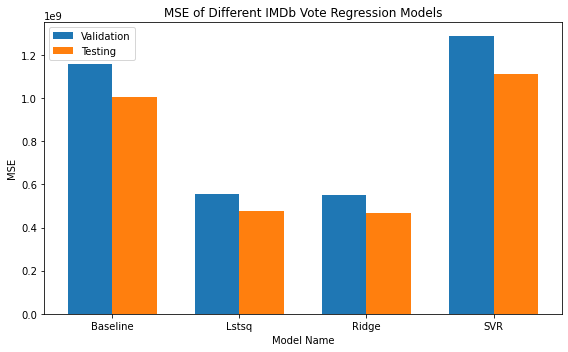

In [66]:
plt.rcParams['figure.figsize'] = [8, 5]

labels = ['Baseline', 'Lstsq', 'Ridge', 'SVR']
valid_mse = [1160280500.6441615,556603919.5365533, 548761978.9901602, 1286909567.6183698]
test_mse = [1003771021.5308051, 476707562.2191069,467182376.16667485, 1114259941.3989758]

x = numpy.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, valid_mse, width, label='Validation')
rects2 = ax.bar(x + width/2, test_mse, width, label='Testing')
ax.set_ylabel('MSE')
ax.set_xlabel('Model Name')
ax.set_title('MSE of Different IMDb Vote Regression Models')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

fig.tight_layout()

plt.show()

SGD Regression left off because of high error rate.